# The power of data pooling

This notebook illustrates the effectiveness of pooling data.

- There are two central states (with 10 replicas each) that sequences stay on until they terminate: A & B.
    - A has a hazard of 0.02
    - B has a hazard of 0.04.
  With an observation window of 5 steps (after which the observation is censored) it's very hard to distinguish which state is better in terms of survival -> you really need a lot of data to get it right.
- There are N treatments states.
  They vary simply in the probability of transitioning to A vs. to B.
  The probability of moving to A induces a natural ordering of treatments
  
We sample 10 sequences starting at each treatment state.
We model survival using a Cox PH model, with a feature vector that's a one-hot encoding of the state ID.
We measure the accuracy of a model by the kendall-tau rank correlation between estimated treatment effect and true 
treatment effect.

**Conclusion**: using TD, the correlation between estimated and true effect increases as the number of treatment increases.
With MC, this is not the case.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pickle

from functools import partial
from scipy.stats import rankdata, kendalltau

from tdsurv.base import Model
from tdsurv import unroll

In [2]:
def corr(params1, params2):
    ranks1 = rankdata(params1, method="average")
    ranks2 = rankdata(params2, method="average")
    tau, _ = kendalltau(ranks1, ranks2)
    return tau

class SparseCoxPH(Model):

    """Space-efficient representation of Cox PH model with one-hot feature vectors."""

    def __init__(self, horizon, n_feats):
        params = jnp.zeros(n_feats + horizon)
        super().__init__(horizon, params)

    @partial(jax.jit, static_argnums=(0,))
    def hazard_logits(self, params, xs):
        return (
            jnp.expand_dims(params[xs], axis=1)
            + params[-self.horizon :]
            #jnp.tile(jnp.expand_dims(params[xs], axis=1), (self.horizon,))
        )

    def score(self, xs):
        return -self.params[xs]

In [3]:
# Hazard probability for two central states A & B.
hazards = np.array([0.02, 0.04])
# Horizon & observation window.
horizon = 5
# Central states replicas.
n_replicas = 10
offset = 2 * n_replicas

def gen_data(trt, p, n, horizon, rng):
    seqs = -np.ones((n, horizon + 1), dtype=int)
    ts = np.zeros(n, dtype=int)
    cs = np.zeros(n, dtype=bool)
    for i in range(n):
        nxt = int(rng.random() < p)  # Index of state A or B.
        t = rng.geometric(hazards[nxt])
        seqs[i, 0] = trt + offset  # Offset by 2 to acocunt for central states.
        seqs[i, 1 : (t + 1)] = n_replicas * nxt + rng.choice(n_replicas)
        # Account for limited observation window (censor if necessary).
        ts[i] = min(1 + t, horizon)
        cs[i] = t >= horizon
    return seqs, ts, cs

In [4]:
# Fraction of observations that will be censored at central states
(1 - hazards)**(horizon - 1)

array([0.92236816, 0.84934656])

In [5]:
%%time
rng = np.random.default_rng(seed=0)

# Maximum number of treatments.
n_treatments = 1000
# Samples per treatment
n_samples = 10
# Cutoffs for training.
cutoffs = np.insert(np.geomspace(10, n_treatments, 10, dtype=int), 0, 0)

n_repetitions = 10
res_td = np.zeros((n_repetitions, 10))
res_mc = np.zeros((n_repetitions, 10))

for i in range(n_repetitions):
    # Probability of moving to state A.
    ps = rng.random(n_treatments)
    model_td = SparseCoxPH(horizon, n_treatments + offset)
    model_mc = SparseCoxPH(horizon, n_treatments + offset)
    seqs = np.zeros((0, 2), dtype=int)
    ts = np.zeros(0, dtype=int)
    cs = np.zeros(0, dtype=bool)
    for j, (z1, z2) in enumerate(zip(cutoffs, cutoffs[1:])):
        print(".", end="", flush=True)
        for trt in np.arange(z1, z2):
            seqs_, ts_, cs_ = unroll(*gen_data(trt, ps[trt], n_samples, horizon, rng), compress=True)
            seqs = np.concatenate((seqs, seqs_))
            ts = np.concatenate((ts, ts_))
            cs = np.concatenate((cs, cs_))
        model_td.fit(seqs, ts, cs, lambda_=0.0, l2=1.0, n_iters=10)
        model_mc.fit(seqs, ts, cs, lambda_=1.0, l2=1.0)
        res_td[i, j] = corr(model_td.params[offset : offset + z2], ps[:z2])
        res_mc[i, j] = corr(model_mc.params[offset : offset + z2], ps[:z2])
    print()

..........
..........
..........
..........
..........
..........
..........
..........
..........
..........
CPU times: user 3min 33s, sys: 3.45 s, total: 3min 36s
Wall time: 2min 9s


(0.0, 1.0)

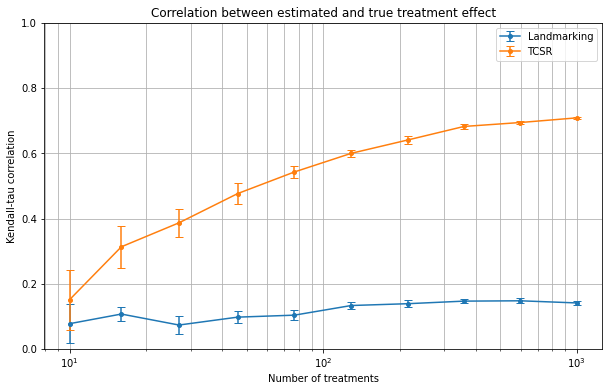

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))

xs = cutoffs[1:]

ax.errorbar(
    x=xs,
    y=np.mean(res_mc, axis=0),
    yerr=np.std(res_mc, axis=0) / np.sqrt(n_repetitions),
    marker="o",
    markersize=4,
    capsize=4,
    label="Landmarking",
)
ax.errorbar(
    x=xs,
    y=np.mean(res_td, axis=0),
    yerr=np.std(res_td, axis=0) / np.sqrt(n_repetitions),
    marker="o",
    markersize=4,
    capsize=4,
    label="TCSR",
)
ax.grid(axis="both", which="both")
ax.legend()
ax.set_xlabel("Number of treatments")
ax.set_ylabel("Kendall-tau correlation")
ax.set_title("Correlation between estimated and true treatment effect")
ax.set_xscale("log", base=10)
ax.set_ylim(bottom=0.0, top=1.0)

The plot shows the mean and the standard error over 10 independent experiments.

In [7]:
with open("../data/datapool.pkl", "wb") as f:
    pickle.dump({
        "xs": cutoffs[1:],
        "td": res_td,
        "mc": res_mc,
    }, f)